# Chapter 3: Vector Autoregressive Methods

**Introduction**

Previously, we have introduced the classical approaches in forecasting single/univariate time series like the 
Autoregressive-Moving-Average (ARIMA) model and the simple linear regression model. We learned that stationarity is a condition that is necessary when using ARIMA while this need not be imposed when using the linear regression model. In this notebook, we extend the forecasting problem to a more generalized framework where we deal with **multivariate time series**--time series which has more than one time-dependent variable. More specifically, we introduce **vector autoregressive (VAR)** models and show how they can be used in forecasting mutivariate time series. 

**Chapter Outline**
* Multivariate Time Series model
    * Motivation
    * Univariate VS Multivariate Time Series
    * Examples
    * Foundations
* Vector Autoregressive (VAR) Models
    * VAR(1) model
    * VAR(*p*) model
    * Choosing the order *p*
* Building a VAR model
* Structural Analysis
    * Impulse Response Function
    * Forecast Error Variance Decomposition 
* Takeaways
* References

**References**: The contents of this notebook are compiled from the references listed [here](VARreferences.txt).

Prepared by: Maria Eloisa Ventura

## Multivariate Time Series Model

### Motivation
- To understand the dynamic relationships over time among the series
- To improve accuracy of forecasts for individual series by utilizing the additional information available from the related series in the forecasts for each series

### Definition: Univariate vs Multivariate Time Series

Time series can either be univariate or multivariate. The term **univariate time series** consists of single observations recorded sequentially over equal time increments. When dealing with a univariate time series model (e.g., ARIMA), we usually refer to a model that contains lag values of itself as the independent variable. 

On the other hand, a **multivariate time series** has more than one time-dependent variables. For a multivariate process, several related time series are observed simultaneously over time. As an extension of the univariate case, the multivariate time series model involves two or more input variables, and leverages the interrelationship among the different time series variables. 

In [1]:
import numpy as np
import pandas as pd
import statsmodels.tsa as tsa
from statsmodels.tsa.vector_ar.var_model import VAR, FEVD
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf, kpss, coint
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import matplotlib.pyplot as plt
import mvts_utils as utils
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

### Examples of Multivariate Time Series

#### Air Quality Data from UCI

The dataset contains hourly averaged measurements obtained from an Air Quality Chemical Multisensor Device which was located on the field of polluted area at an Italian city. The dataset can be downloaded __[here](https://archive.ics.uci.edu/ml/datasets/Air+Quality#)__.

In [2]:
aq_df = pd.read_excel("../data/AirQualityUCI/AirQualityUCI.xlsx", parse_dates=[['Date', 'Time']])\
            .set_index('Date_Time').replace(-200, np.nan).interpolate()
aq_df.head(2)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.00,150.0,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.6,48.875001,0.757754
2004-03-10 19:00:00,2.0,1292.25,112.0,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.3,47.700000,0.725487


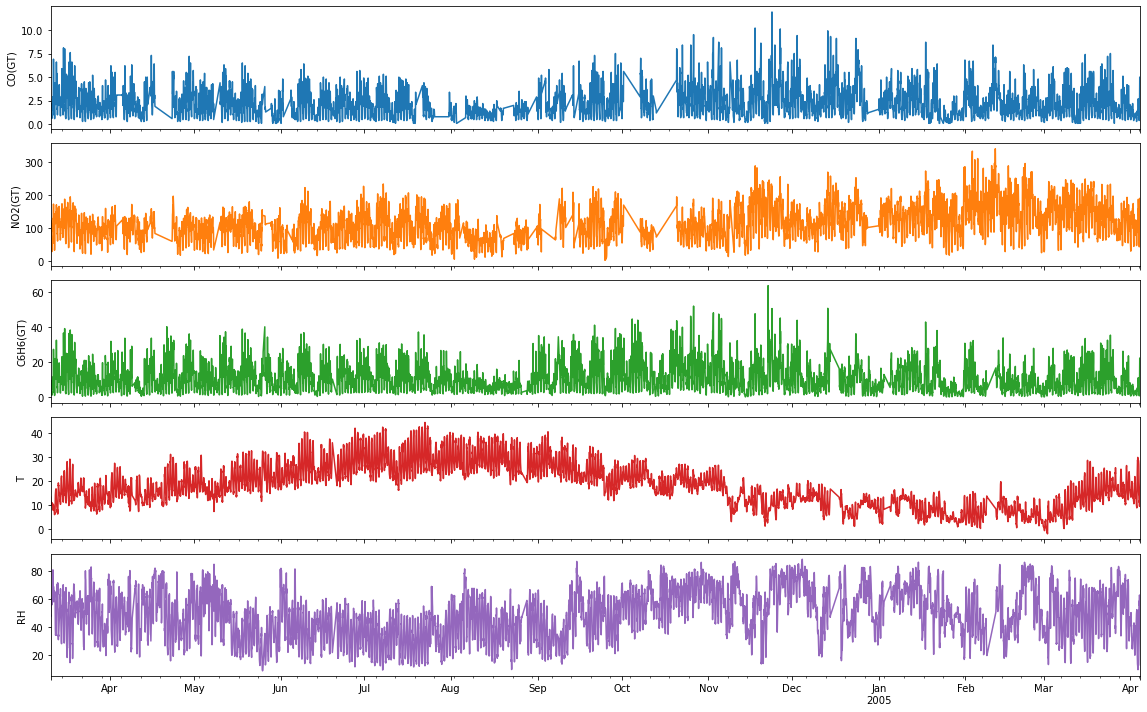

In [3]:
fig,ax = plt.subplots(5, figsize=(16,10), sharex=True)
plot_cols = ['CO(GT)', 'NO2(GT)', 'C6H6(GT)', 'T', 'RH']
aq_df[plot_cols].plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)): 
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

#### Global Health from The World Bank

This dataset combines key health statistics from a variety of sources to provide a look at global health and population trends. It includes information on nutrition, reproductive health, education, immunization, and diseases from over 200 countries. The dataset can be downloaded __[here](https://console.cloud.google.com/marketplace/product/the-world-bank/global-health?filter=solution-type:dataset&filter=category:health&id=f3c38e10-2c45-43c8-8a12-8d749ba987ee)__.

In [4]:
ind_df = pd.read_csv('../data/WorldBankHealth/WorldBankHealthPopulation_SeriesSummary.csv')\
            .loc[:,['series_code', 'indicator_name']].drop_duplicates().reindex()\
            .sort_values('indicator_name').set_index('series_code')
hn_df = pd.read_csv('../data/WorldBankHealth/WorldBankHealthPopulation_HealthNutritionPopulation.csv')\
            .pivot(index='year', columns='indicator_code', values='value')

cols = ['SH.XPD.KHEX.GD.ZS', 'SH.XPD.CHEX.GD.ZS', 'SH.XPD.GHED.GD.ZS']
health_expenditure_df = hn_df.loc[np.arange(2000, 2018), cols]\
    .rename(columns = dict(ind_df.loc[cols].indicator_name\
                           .apply(lambda x: '_'.join(x.split('(')[0].split(' ')[:-1]))))
health_expenditure_df.index = pd.date_range('2000-1-1', periods=len(health_expenditure_df), freq="A-DEC")
health_expenditure_df.head(2)

indicator_code,Capital_health_expenditure,Current_health_expenditure,Domestic_general_government_health_expenditure
2000-12-31,0.013654,3.154818,1.400685
2001-12-31,0.012675,2.947059,1.196554


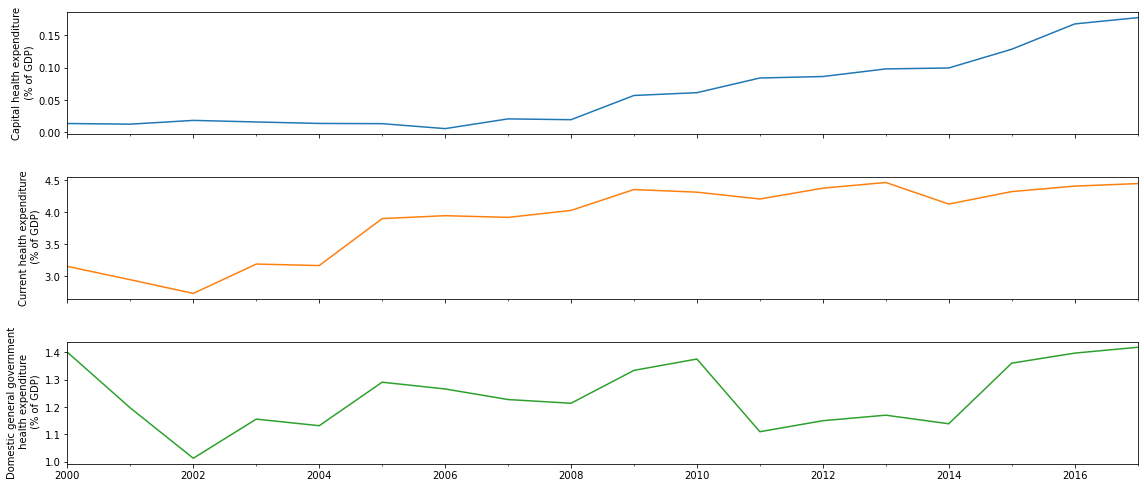

In [5]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(16, 7))
health_expenditure_df.plot(subplots=True, ax=ax, legend=False)
y_label = ['Capital health expenditure', 'Current health expenditure',
           'Domestic general government\n health expenditure']
for a in range(len(ax)): 
    ax[a].set_ylabel(f"{y_label[a]}\n (% of GDP)")
plt.tight_layout()
plt.show()

#### US Treasury Rates
January, 1982 – December, 2016  (Weekly)
https://essentialoftimeseries.com/data/
This sample dataset contains weekly data of US Treasury rates from January 1982 to December 2016. The dataset can be downloaded __[here](https://essentialoftimeseries.com/data/)__.

In [6]:
treas_df = pd.read_excel("../data/USTreasuryRates/us-treasury-rates-weekly.xlsx")
treas_df = treas_df.rename(columns={'Unnamed: 0': 'Date'}).set_index('Date')
treas_df.index = pd.to_datetime(treas_df.index)
treas_df.head(1)

,1-month,3-month,6-month,1-year,2-year,3-year,5-year,7-year,10-year,Excess CRSP Mkt Returns,10-year Treasury Returns,Term spread,Change in term spread,5-year Treasury Returns,Unnamed: 15,Excess 10-year Treasury Returns,Term Spread,VXO,Delta VXO
Date,,,,,,,,,,,,,,,,,,,
1982-01-08,10.296,12.08,13.36,13.8,14.12,14.32,14.46,14.54,14.47,-1.632,NaN,2.39,NaN,NaN,NaN,-0.286662,1.729559,20.461911,-0.003106


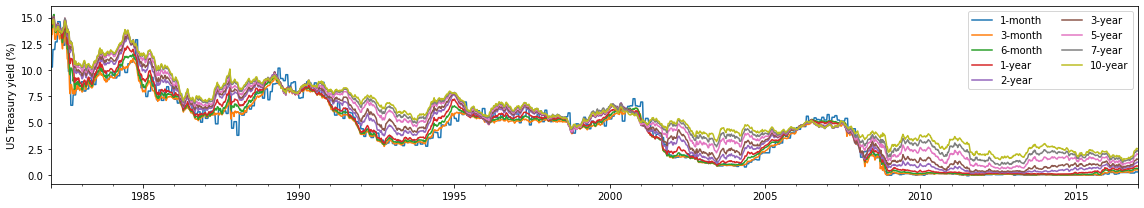

In [7]:
fig,ax = plt.subplots(1, figsize=(16, 3), sharex=True)
data_df = treas_df.iloc[:, 0:9]
data_df.plot(ax=ax)
plt.ylabel('US Treasury yield (%)')
plt.xlabel('')
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

#### Jena Weather Data
Weather timeseries dataset recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany from 2009 to 2016. It contains 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes. You can download the data __[here](https://www.kaggle.com/stytch16/jena-climate-2009-2016)__.

In [8]:
jena_data = pd.read_csv('../data/jena_climate_2009_2016.csv')
jena_data['Date Time'] = pd.to_datetime(jena_data['Date Time'])
jena_data = jena_data.set_index('Date Time')
jena_data.head(3)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6


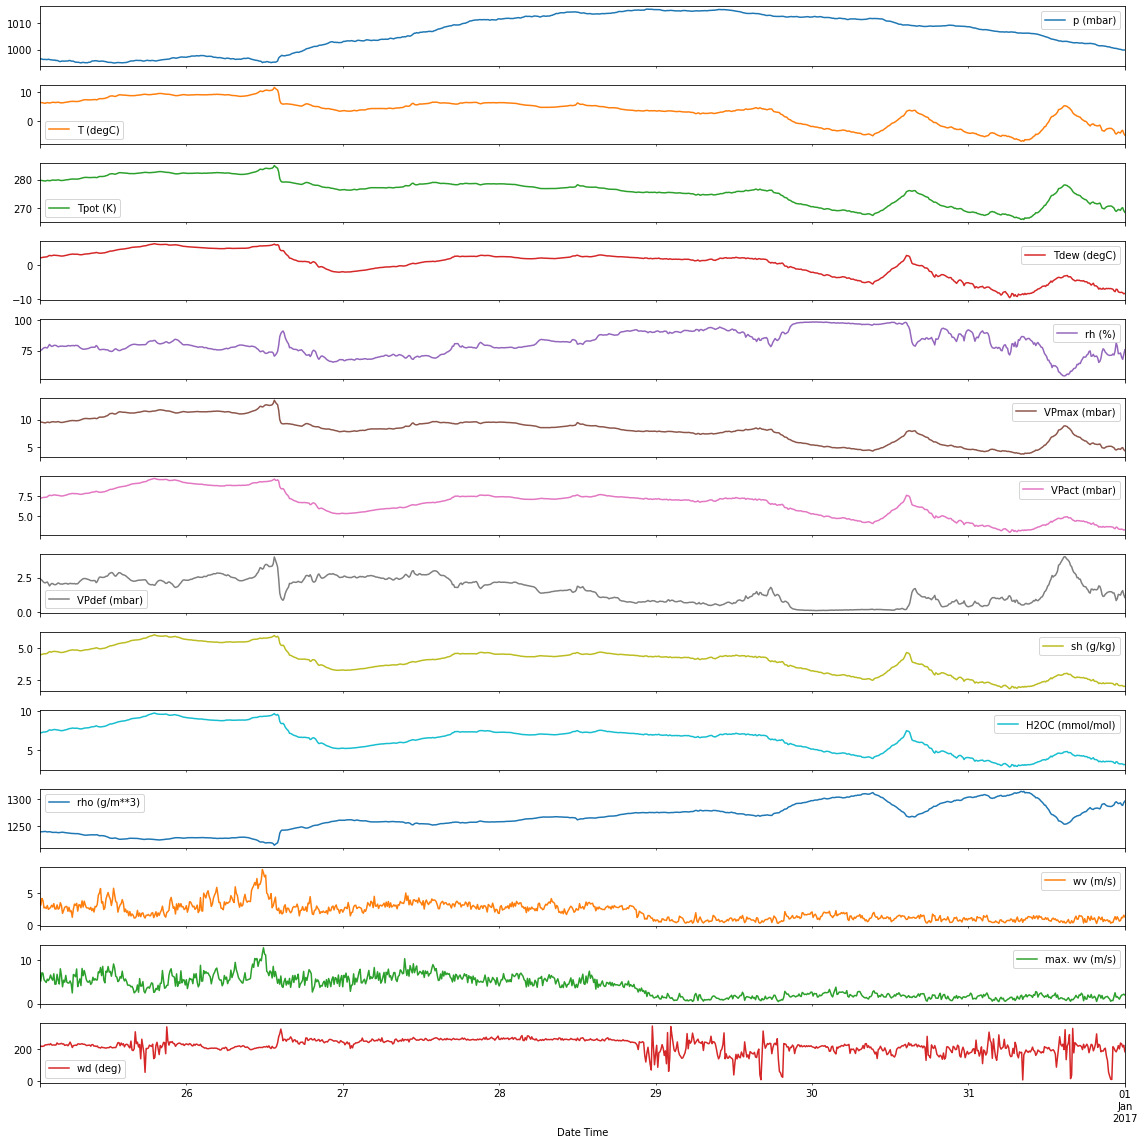

In [9]:
fig,ax = plt.subplots(jena_data.shape[-1], figsize=(16,16), sharex=True)
jena_data.iloc[-1000:].plot(subplots=True, ax=ax)
plt.tight_layout()
plt.show()

### Foundations
Before we discuss VARs, we outline some fundamental concepts below that we'll need to understand the model. 

##### Weak Stationarity of Multivariate Time Series
As in the univariate case, one of the requirements that we need to satisfy before we can apply VAR models is stationarity--in particular, weak stationarity. Both in the univariate and multivariate case, the first two moments of the time series are time-invariant. More formally, we describe weak stationarity below. 


Consider a $N$-dimensional time series, $\mathbf{y}_t = \left[y_{1,t}, y_{2,t}, ..., y_{N,t}\right]^\prime$. This is said to be weakly stationary if the first two moments are finite and constant through time, that is,
1. $E\left[\mathbf{y}_t\right] = \boldsymbol{\mu}$
2. $E\left[(\mathbf{y}_t-\boldsymbol{\mu})(\mathbf{y}_t-\boldsymbol{\mu})^\prime\right] \equiv \boldsymbol\Gamma_0 < \infty$ for all $t$
3. $E\left[(\mathbf{y}_t-\boldsymbol{\mu})(\mathbf{y}_{t-h}-\boldsymbol{\mu})^\prime\right] \equiv \boldsymbol\Gamma_h$ for all $t$ and $h$

where the expectations are taken element-by-element over the joint distribution of $\mathbf{y}_t$:
- $\boldsymbol{\mu}$ is the vector of means $\boldsymbol\mu = \left[\mu_1, \mu_2, ..., \mu_N \right]$
- $\boldsymbol\Gamma_0$ is the $N\times N$ covariance matrix where the $i$th diagonal element is the variance of $y_{i,t}$, and the $(i, j)$th element is the covariance between $y_{i,t}$ and ${y_{j,t}}$
- $\boldsymbol\Gamma_h$ is the cross-covariance matrix at lag $h$

#####  Obtaining Cross-Correlation Matrix from Cross-Covariance Matrix
When dealing with a multivariate time series, we can examine the predictability of one variable on another by looking at the relationship between them using the cross-covariance function (CCVF) and cross-correlation function (CCF). To do this, we begin by defining the cross-covariance between two variables, then we estimate the cross-correlation between one variable and another variable that is time-shifted. This informs us whether one time series may be related to the past lags of the other. In other words, CCF is used for identifying lags of one variable that might be useful as a predictor of the other variable. 

**At lag 0**:

Let $\mathbf\Gamma_0$ be the covariance matrix at lag 0, $\mathbf D$ be a $N\times N$ diagonal matrix containing the standard deviations of $y_{i,t}$ for $i=1, ..., N$. The correlation matrix of $\mathbf{y}_t$ is defined as

$$\boldsymbol\rho_0 = \mathbf D^{-1}\mathbf\Gamma_0\mathbf D^{-1}$$

where the $(i, j)$th element of $\boldsymbol\rho_0$ is the correlation coefficient between $y_{i,t}$ and $y_{j,t}$ at time $t$:

$$\rho_{i,j}(0) = \dfrac{Cov\left[y_{i,t}, y_{j,t} \right]}{\sigma_{i,t} \sigma_{j,t}}$$

**At lag h**:

Let $\boldsymbol\Gamma_h = E\left[(\mathbf{y}_t-\boldsymbol{\mu})(\mathbf{y}_{t-h}-\boldsymbol{\mu})^\prime\right]$ be the lag-$h$ covariance cross-covariance matrix of $\mathbf y_{t}$. The lag-$h$ cross-correlation matrix is defined as

$$\boldsymbol\rho_h = \mathbf D^{-1}\mathbf\Gamma_h\mathbf D^{-1}$$

The $(i,j)$th element of $\boldsymbol\rho_h$ is the correlation coefficient between $y_{i,t}$ and $y_{j,t-h}$:

$$\rho_{i,j}(h) = \dfrac{Cov\left[y_{i,t}, y_{j,t-h} \right]}{\sigma_{i,t} \sigma_{j,t}}$$


**What do we get from this?**

|Correlation Coefficient| Interpretation |
|:----|:----|
|$\rho_{i,j}(0)\neq0$|$y_{i,t}$ and $y_{j,t}$ are *contemporaneously linearly correlated*|
|$\rho_{i,j}(h)=\rho_{j,i}(h)=0$ for all $h\geq0$|$y_{i,t}$ and $y_{j,t}$ share *no linear relationship*|
|$\rho_{i,j}(h)=0$ and $\rho_{j,i}(h)=0$ for all $h>0$|$y_{i,t}$ and $y_{j,t}$ are said to be linearly *uncoupled*|
|$\rho_{i,j}(h)=0$ for all $h>0$, but $\rho_{j,i}(q)\neq0$ for at least some $q>0$|There is a *unidirectional (linear) relationship* between $y_{i,t}$ and $y_{j,t}$, where $y_{i,t}$ does not depend on $y_{j,t}$, but $y_{j,t}$ depends on (some) lagged values of $y_{i,t}$|
|$\rho_{i,j}(h)\neq0$ for at least some $h>0$ and $\rho_{j,i}(q)\neq0$ for at least some $q>0$|There is a *bi-directional (feedback) linear relationship* between $y_{i,t}$ and $y_{j,t}$|

## Vector Autoregressive (VAR) Models 

- Generalization of the univariate AR model
- System regression model that treats all the variables as endogenous
- Allows each of the variables to depend on $p$ lagged values of itself and of all the other variables in the system

A VAR model of order $p$ can be represented as

$$\mathbf y_t=\mathbf a_0 + \mathbf A_1 \mathbf y_{t-1} + \mathbf A_2 \mathbf y_{t-2} + ... + \mathbf A_p \mathbf y_{t-p} + \mathbf u_t = \mathbf a_0  + \sum_{j=1}^{p} \mathbf A_j \mathbf y_{t-j} + \mathbf u_t$$

where $\mathbf y_t$ is a $N\times 1$ vector containing $N$ endogenous variables, $\mathbf a_0$ is a $N\times 1$ vector of constants, $\mathbf A_1, \mathbf A_2, ..., \mathbf A_p$ are the $p$ $N\times N$ matrices of autoregressive coefficients, and $\mathbf u_t$ is a $N\times 1$ vector of white noise disturbances. 

### VAR(1) Model

#### Structural and Reduced Form

Consider the following bivariate system

$$ y_{1,t} = b_{1,0} - b_{1,2}y_{2,t} +  \varphi_{1,1}y_{1,t-1} + \varphi_{1,2}y_{2,t-1} + \varepsilon_{1,t}$$

$$ y_{2,t} = b_{2,0} - b_{2,1}y_{2,t} +  \varphi_{2,1}y_{1,t-1} + \varphi_{2,2}y_{2,t-1} + \varepsilon_{2,t}$$

where both $y_{1,t}$ and $y_{2,t}$ are assumed to be stationary, and $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are the uncorrelated error terms with standard deviation $\sigma_{1,t}$ and $\sigma_{2,t}$, respectively. 

In matrix notation: 

\begin{equation*}
\begin{bmatrix}
1 & b_{1,2}\\
b_{2,1} & 1
\end{bmatrix} 
\begin{bmatrix}
y_{1,t} \\
y_{2,t}
\end{bmatrix} = 
\begin{bmatrix}
b_{1,0} \\
b_{2,0}
\end{bmatrix} + 
\begin{bmatrix}
\varphi_{1,1} & \varphi_{1,2}\\
\varphi_{2,1} & \varphi_{2,2}
\end{bmatrix} 
\begin{bmatrix}
y_{1,t-1} \\
y_{2,t-1}
\end{bmatrix} +
\begin{bmatrix}
\varepsilon_{1,t} \\
\varepsilon_{2,t}
\end{bmatrix}
\end{equation*}

Let 
\begin{equation*}
\mathbf B \equiv \begin{bmatrix}
1 & b_{1,2}\\
b_{2,1} & 1
\end{bmatrix}, 
\mathbf y_{t} \equiv
\begin{bmatrix}
y_{1,t} \\
y_{2,t}
\end{bmatrix},
\mathbf Q_0 \equiv
\begin{bmatrix}
b_{1,0} \\
b_{2,0}
\end{bmatrix}, 
\mathbf Q_1 \equiv
\begin{bmatrix}
\varphi_{1,1} & \varphi_{1,2}\\
\varphi_{2,1} & \varphi_{2,2}
\end{bmatrix}, \end{equation*}
\begin{equation*}
\mathbf y_{t-1} \equiv
\begin{bmatrix}
y_{1,t-1} \\
y_{2,t-1}
\end{bmatrix},
\boldsymbol \varepsilon_t \equiv
\begin{bmatrix}
\varepsilon_{1,t} \\
\varepsilon_{2,t}
\end{bmatrix}
\end{equation*}

then 

$$\mathbf B \mathbf y_t = \mathbf Q_0 + \mathbf Q_1 \mathbf y_{t-1} + \boldsymbol\varepsilon_t$$

**Structural VAR (VAR in primitive form)**
- Described by equation above
- Captures contemporaneous feedback effects ($b_{1,2}, b_{2,1}$)
- Not very practical to use 
- Contemporaneous terms cannot be used in forecasting
- Needs further manipulation to make it more useful (e.g. multiplying the matrix equation by $\mathbf B^{-1}$)

Multiplying the matrix equation by $\mathbf B^{-1}$), we get

$$\mathbf y_t = \mathbf a_0 + \mathbf A_1 \mathbf y_{t-1} + \mathbf u_t$$

or 

$$\mathbf y_t = \mathbf a_0 + \mathbf A_1 L\mathbf y_t + \mathbf u_t$$

where $\mathbf a_0 = \mathbf B^{-1}\mathbf Q_0$, $\mathbf A_1 = \mathbf B^{-1}\mathbf Q_1$, $L$ is the lag/backshift operator, and $\mathbf u_t = \mathbf B^{-1}\boldsymbol\varepsilon_t$, equivalently,

$$ y_{1,t} = a_{1,0} + a_{1,1}y_{1,t-1} + a_{1,2}y_{2,t-1} + u_{1,t}$$

$$ y_{2,t} = a_{2,0} + a_{2,1}y_{1,t-1} + a_{2,2}y_{2,t-1} + u_{2,t}$$

###### Reduced-form VAR (VAR in standard form)
- Described by equation above
- Only dependent on lagged endogenous variables (no contemporaneous feedback)
- Can be estimated using ordinary least squares (OLS)

#### VMA infinite representation and Stationarity

Consider the reduced form, standard VAR(1) model

$$\mathbf y_t = \mathbf a_0 + \mathbf A_1 \mathbf y_{t-1} + \mathbf u_t$$

Assuming that the process is weakly stationary and taking the expectation of $\mathbf y_t$, we have

$$E\left[\mathbf y_t\right] = \mathbf a_0 + \mathbf A_1 E\left[\mathbf y_{t-1}\right]$$

where $E\left[\mathbf u_t\right]=0.$ If we let $\tilde{\mathbf y}_{t}\equiv \mathbf y_t - \boldsymbol \mu$ be the mean-corrected time-series, we can write the model as

$$\tilde{\mathbf y}_{t} = \mathbf A_1 \tilde{\mathbf y}_{t-1} + \mathbf u_t$$

Substituting $\tilde{\mathbf y}_{t-1} = \mathbf A_1 \tilde{\mathbf y}_{t-2} + \mathbf u_{t-1}$, 

$$\tilde{\mathbf y}_{t} = \mathbf A_1 \left( \mathbf A_1 \tilde{\mathbf y}_{t-2} + \mathbf u_{t-1}\right)+ \mathbf u_t$$

If we keep iterating, we get

$$\mathbf y_{t} = \boldsymbol\mu + \sum_{i=1}^{\infty} \mathbf A_1^i  \mathbf u_{t-i} + \mathbf u_t$$

Letting $\boldsymbol\Theta_i\equiv A_1^i$, we get the **VMA infinite representation**


$$\mathbf y_{t} = \boldsymbol\mu + \sum_{i=1}^{\infty} \boldsymbol\Theta_i  \mathbf u_{t-i} + \mathbf u_t$$



###### Stationarity of the VAR(1) model
- All the N eigenvalues of the matrix $A_1$ must be less than 1 in modulus, to avoid that the coefficient matrix $A_1^j$ will either explode or converge to a nonzero matrix as $j$ goes to infinity.
- Provided that the covariance matrix of $u_t$ exists, the requirement that all the eigenvalues of $A_1$ are less than one in modulus is a necessary and sufficient condition for $y_t$ to be stable, and thus, stationary. 
- All roots of $det\left(\mathbf I_N - \mathbf A_1 z\right)=0$ must lie outside the unit circle. 

### VAR(p) Model

Consider the VAR(p) model described by 

$$\mathbf y_t=\mathbf a_0 + \mathbf A_1 \mathbf y_{t-1} + \mathbf A_2 \mathbf y_{t-2} + ... + \mathbf A_p \mathbf y_{t-p} + \mathbf u_t = \mathbf a_0  + \sum_{j=1}^{p} \mathbf A_j \mathbf y_{t-j} + \mathbf u_t$$

Using the lag operator $L$, we get 

$$\tilde{\mathbf A} (L) \mathbf y_t = \mathbf a_0 + \mathbf u_t$$

where $\tilde{\mathbf A} (L) = (\mathbf I_N - A_1 L - ... - A_p L^p)$. Assuming that $\mathbf y_t$ is weakly stationary, we obtain that 

$$\boldsymbol\mu = E\left[\mathbf y_t\right] = (\mathbf I_N - A_1 L - ... - A_p L^p)^{-1} \mathbf a_0$$

Defining $\tilde{\mathbf y}_t=\mathbf y_t -\boldsymbol\mu$, we have

$$\tilde{\mathbf y}_t =  \mathbf A_1 \tilde{\mathbf y}_{t-1} + \mathbf A_2 \tilde{\mathbf y}_{t-2} + ... + \mathbf A_p \tilde{\mathbf y}_{t-p} + \mathbf u_t$$

###### Properties
- $Cov[\mathbf y_t, \mathbf u_t] = \Sigma_u$, the covariance matrix of $\mathbf u_t$
- $Cov[\mathbf y_{t-h}, \mathbf u_t] = \mathbf 0$ for any $h>0$
- $\boldsymbol\Gamma_h = \mathbf A_1 \boldsymbol\Gamma_{h-1} +...+\mathbf A_p \boldsymbol\Gamma_{h-p}$ for $h>0$
- $\boldsymbol\rho_h = \boldsymbol \Psi_1 \boldsymbol\Gamma_{h-1} +...+\boldsymbol \Psi_p \boldsymbol\Gamma_{h-p}$ for $h>0$, where $\boldsymbol \Psi_i = \mathbf D^{-1/2}\mathbf A_i D^{-1/2}$

######  Stationarity
- All roots of $det\left(\mathbf I_N - \mathbf A_1 z - ...-  \mathbf A_p z^p\right)=0$ must lie outside the unit circle.

### Specification of a VAR model: Choosing the order *p*

#### Using information criterion

To select the appropriate lag length, we minimize the multivariate version of the information criteria presented previously: 

*Akaike's (1973) information criterion*
$$(M)\operatorname{AIC} = \operatorname{ln}|\tilde{\boldsymbol\Sigma}_u | + 2\dfrac{k}{T}$$

*Schwarz’s (1978) Bayesian information criterion's information criterion*
$$(M)\operatorname{BIC} = \operatorname{ln}|\tilde{\boldsymbol\Sigma}_u | + \dfrac{k}{T}\operatorname{ln}(T)$$

*Hannan-Quinn’s (1979) information criterion*
$$(M)\operatorname{HQIC} = \operatorname{ln}|\tilde{\boldsymbol\Sigma}_u | + \dfrac{k}{T}\operatorname{ln}(\operatorname{ln}(T))$$

where $M$ stands for multivariate, $\tilde{\boldsymbol\Sigma}_u$ is the estimated covariance matrix of the residuals, $T$ is the number of observations in the sample, and $k$ is the total number of equations in the VAR($p$) (i.e. $N^2p + N$ where $N$ is the number of equations and $p$ is the number of lags).

#### Additional criterion: 
*Final prediction error*

$$\operatorname{FPE}(p) = \left[\dfrac{T+Np+1}{T-Np+1} \right]^N |\tilde{\boldsymbol\Sigma}_u | $$



## Building a VAR model
In this section, we show how we can use the VAR model to forecast the air quality data. The following steps are shown below: 
1. Check for stationarity.
2. Split data into train and test sets.
3. Select the VAR order *p* that gives. 
4. Fit VAR model of order *p* on the train set. 
5. Generate forecast. 
6. Evaluate model performance. 

For illustration, we consider the carbon monoxide, nitrous dioxide  and relative humidity time series from the Air Quality Dataset from 1 October 2014. 

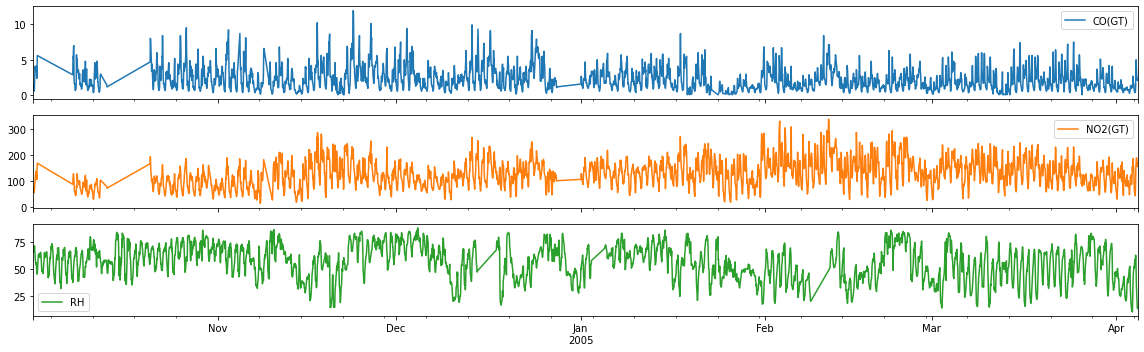

In [10]:
cols = ['CO(GT)', 'NO2(GT)', 'RH']
data_df = aq_df.loc[aq_df.index>'2004-10-01',cols]
fig,ax = plt.subplots(3, figsize=(16, 5), sharex=True)
data_df.plot(ax=ax, subplots=True)
plt.xlabel('')
plt.tight_layout()
plt.show()

##### Quick inspection before we proceed with modeling...
To find out whether the multivariate approach is better than treating the signals separately as univariate time series, we examine the relationship between the variables using CCF. The sample below shows the CCF for the last 100 data points of the Air quality data for CO, NO2 and RH. 

*CO and NO2*

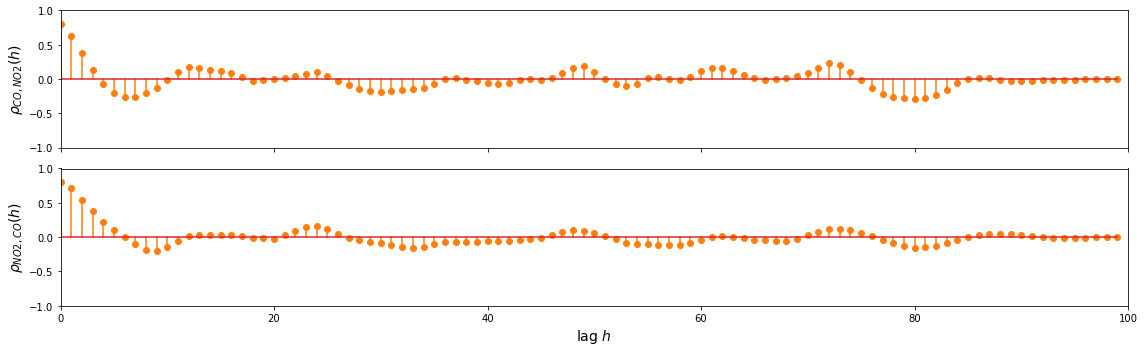

In [11]:
sample_df = data_df.iloc[-100:]
ccf_y1_y2 = ccf(sample_df['CO(GT)'], sample_df['NO2(GT)'], unbiased=False)
ccf_y2_y1 = ccf(sample_df['NO2(GT)'], sample_df['CO(GT)'], unbiased=False)

fig, ax = plt.subplots(2, figsize=(16, 5), sharex=True, sharey=True)
d=1
ax[0].stem(np.arange(len(sample_df))[::d], ccf_y1_y2[::d], linefmt='C1-', markerfmt='C1o')
ax[1].stem(np.arange(len(sample_df))[::d], ccf_y2_y1[::d], linefmt='C1-', markerfmt='C1o')
ax[-1].set_ylim(-1, 1)
ax[0].set_xlim(0, 100)
ax[-1].set_xlabel('lag $h$', fontsize=14)
ax[0].set_ylabel(r'$\rho_{CO,NO2} (h)$', fontsize=14)
ax[1].set_ylabel(r'$\rho_{NO2,CO} (h)$', fontsize=14)
plt.tight_layout()
plt.show()

*CO and RH*

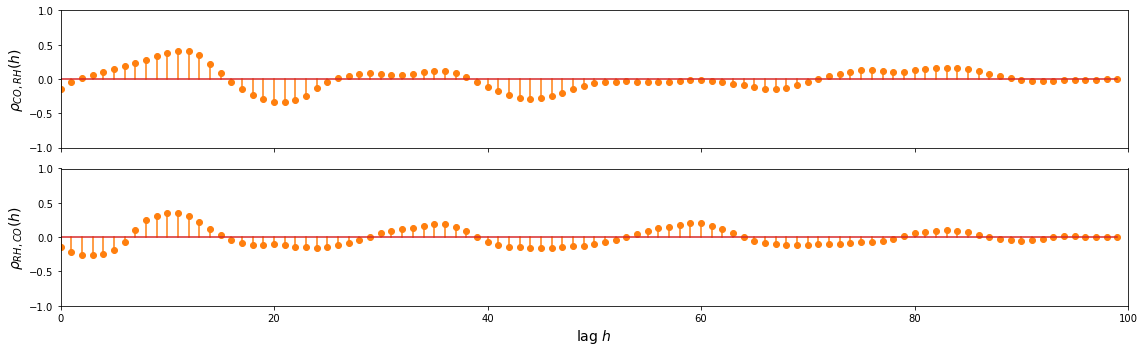

In [12]:
ccf_y1_y2 = ccf(sample_df['CO(GT)'], sample_df['RH'], unbiased=False)
ccf_y2_y1 = ccf(sample_df['RH'], sample_df['CO(GT)'], unbiased=False)

fig, ax = plt.subplots(2, figsize=(16, 5), sharex=True, sharey=True)
d=1
ax[0].stem(np.arange(len(sample_df))[::d], ccf_y1_y2[::d], linefmt='C1-', markerfmt='C1o')
ax[1].stem(np.arange(len(sample_df))[::d], ccf_y2_y1[::d], linefmt='C1-', markerfmt='C1o')
ax[-1].set_ylim(-1, 1)
ax[0].set_xlim(0, 100)
ax[-1].set_xlabel('lag $h$', fontsize=14)
ax[0].set_ylabel(r'$\rho_{CO,RH} (h)$', fontsize=14)
ax[1].set_ylabel(r'$\rho_{RH,CO} (h)$', fontsize=14)
plt.tight_layout()
plt.show()

*RH and NO2*

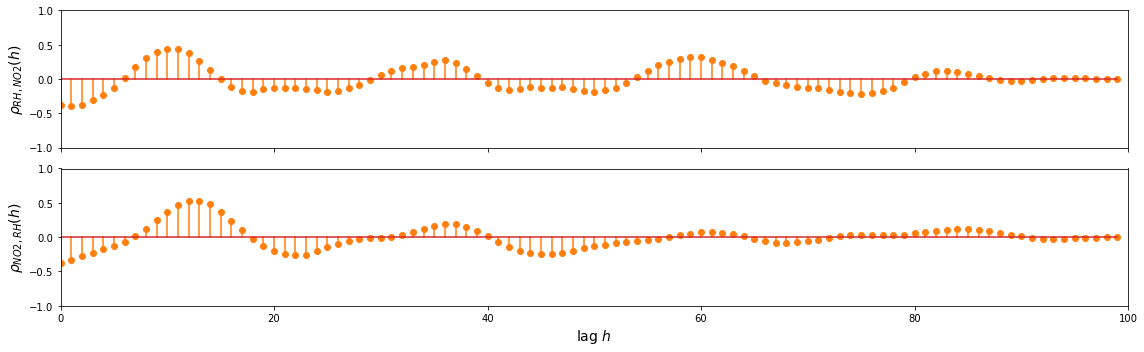

In [13]:
ccf_y1_y2 = ccf(sample_df['RH'], sample_df['NO2(GT)'], unbiased=False)
ccf_y2_y1 = ccf(sample_df['NO2(GT)'], sample_df['RH'], unbiased=False)

fig, ax = plt.subplots(2, figsize=(16, 5), sharex=True, sharey=True)
d=1
ax[0].stem(np.arange(len(sample_df))[::d], ccf_y1_y2[::d], linefmt='C1-', markerfmt='C1o')
ax[1].stem(np.arange(len(sample_df))[::d], ccf_y2_y1[::d], linefmt='C1-', markerfmt='C1o')
ax[-1].set_ylim(-1, 1)
ax[0].set_xlim(0, 100)
ax[-1].set_xlabel('lag $h$', fontsize=14)
ax[0].set_ylabel(r'$\rho_{RH,NO2} (h)$', fontsize=14)
ax[1].set_ylabel(r'$\rho_{NO2,RH} (h)$', fontsize=14)
plt.tight_layout()
plt.show()

**Observation/s**: 

As shown in the plot above, we can see that there's a relationship between:
* CO and some lagged values of RH and NO2
* NO2 and some lagged values of RH and CO
* RH and some lagged values of CO and NO2

This shows that we can benefit from the multivariate approach, so we proceed with building the VAR model. 

### 1. Check stationarity

To check for stationarity, we use the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test and the Augmented Dickey-Fuller (ADF) test. For the data to be suitable for VAR modelling, we need each of the variables in the multivariate time series to be stationary. In both tests, we need the test statistic to be less than the critical values to say that a time series (a variable) to be stationary. 

###### Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test
Recall: Null hypothesis is that an observable time series is stationary around a deterministic trend (i.e. trend-stationary) against the alternative of a unit root.

In [14]:
test_stat, p_val = [], []
cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
for c in data_df.columns: 
    kpss_res = kpss(data_df[c].dropna(), regression='ct')
    test_stat.append(kpss_res[0])
    p_val.append(kpss_res[1])
    cv_1pct.append(kpss_res[3]['1%'])
    cv_2p5pct.append(kpss_res[3]['1%'])
    cv_5pct.append(kpss_res[3]['5%'])
    cv_10pct.append(kpss_res[3]['10%'])
kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 2.5%': cv_2p5pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct}, 
                         index=data_df.columns).T
kpss_res_df.round(4)

,CO(GT),NO2(GT),RH
Test statistic,0.0702,0.3239,0.1149
p-value,0.1000,0.0100,0.1000
Critical value - 1%,0.2160,0.2160,0.2160
Critical value - 2.5%,0.2160,0.2160,0.2160
Critical value - 5%,0.1460,0.1460,0.1460
Critical value - 10%,0.1190,0.1190,0.1190


**Observation/s**: 

From the KPSS test, CO and RH are stationary. 


###### Augmented Dickey-Fuller (ADF) test
Recall: Null hypothesis is that a unit root is present in a time series sample against the alternative that the time series is stationary.

In [15]:
test_stat, p_val = [], []
cv_1pct, cv_5pct, cv_10pct = [], [], []
for c in data_df.columns: 
    adf_res = adfuller(data_df[c].dropna())
    test_stat.append(adf_res[0])
    p_val.append(adf_res[1])
    cv_1pct.append(adf_res[4]['1%'])
    cv_5pct.append(adf_res[4]['5%'])
    cv_10pct.append(adf_res[4]['10%'])
adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct}, 
                         index=data_df.columns).T
adf_res_df.round(4)

,CO(GT),NO2(GT),RH
Test statistic,-7.0195,-6.7695,-6.8484
p-value,0.0000,0.0000,0.0000
Critical value - 1%,-3.4318,-3.4318,-3.4318
Critical value - 5%,-2.8622,-2.8622,-2.8622
Critical value - 10%,-2.5671,-2.5671,-2.5671


**Observation/s**:  

From the ADF test, CO, NO2 and RH are stationary. 


### 2. Split data into train and test sets

We use the dataset from 01 October 2014 to predict the last 24 points (24 hrs/1 day) in the dataset.

In [16]:
forecast_length = 24 
train_df, test_df = data_df.iloc[:-forecast_length], data_df.iloc[-forecast_length:]
test_df = test_df.filter(test_df.columns[~test_df.columns.str.contains('-d')])

### 3. Select order *p*

We compute the different multivariate information criteria (AIC, BIC, HQIC), and FPE. We pick the set of order parameters that correspond to the lowest values. 

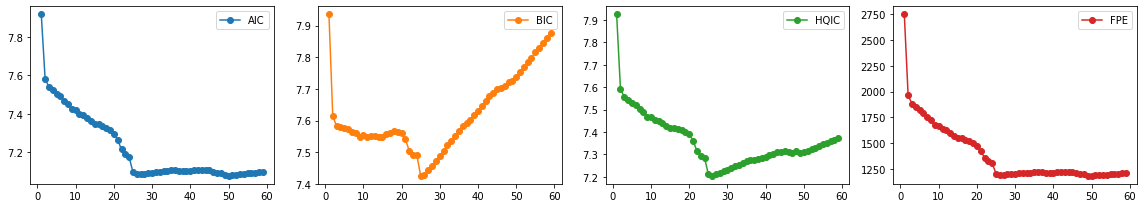

In [17]:
aic, bic, fpe, hqic = [], [], [], []
model = VAR(train_df.dropna())
p = np.arange(1,60)
for i in p:
    result = model.fit(i)
    aic.append(result.aic)
    bic.append(result.bic)
    fpe.append(result.fpe)
    hqic.append(result.hqic)
lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                'BIC': bic, 
                                'HQIC': hqic,
                                'FPE': fpe}, 
                               index=p)    
fig, ax = plt.subplots(1, 4, figsize=(16, 3), sharex=True)
lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
plt.tight_layout()

**Observation/s**: 
- We find BIC and HQIC to be lowest at $p=25$, and we also observe an elbow in the plots for AIC, and FPE, so we choose the number of lags to be 25. 

### 3. Fit VAR model with chosen order

In [18]:
%%time
var_model = model.fit(25)
var_model.summary()

CPU times: user 227 ms, sys: 11.1 ms, total: 239 ms
Wall time: 74.4 ms


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Feb, 2021
Time:                     17:37:04
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    7.42533
Nobs:                     4405.00    HQIC:                   7.21123
Log likelihood:          -34149.0    FPE:                    1205.40
AIC:                      7.09456    Det(Omega_mle):         1145.10
--------------------------------------------------------------------
Results for equation CO(GT)
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.225521         0.069726            3.234           0.001
L1.CO(GT)           0.976458         0.018952           51.523           0.000
L1.NO2(GT)          0.002284         0.000708            3.225     

### 4. Get forecast

In [19]:
forecast_var = pd.DataFrame(var_model.forecast(train_df.values, 
                                              steps=forecast_length), 
                           columns=train_df.columns, 
                           index=test_df.index)
forecast_var = forecast_var.rename(columns={c: c+'-VAR' for c in forecast_var.columns})

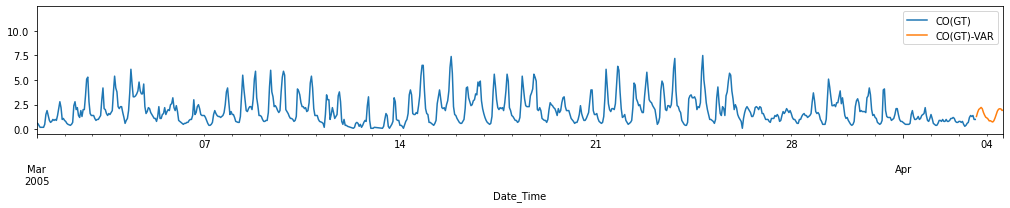

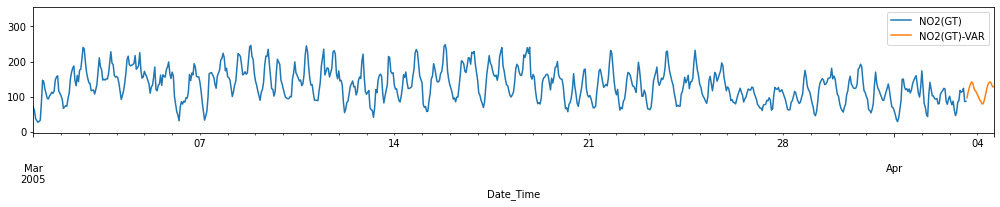

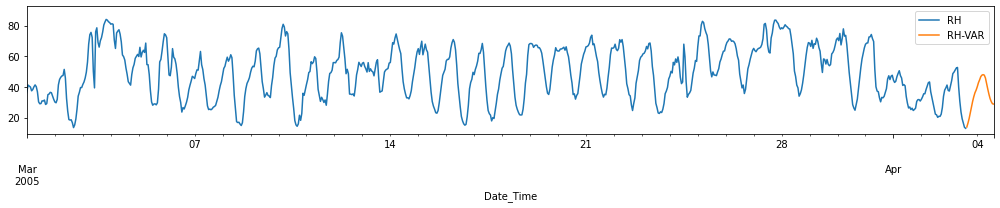

In [20]:
for c in train_df.columns:
    fig, ax = plt.subplots(figsize=[14, 3])
    pd.concat([train_df[[c]], forecast_var[[c+'-VAR']]], axis=1).plot(ax=ax)
    plt.xlim(left=pd.to_datetime('2005-03-01'))
    plt.tight_layout()
    plt.show()

#### Performance Evaluation: Comparison with ARIMA model

When using ARIMA, we treat each variable as a univariate time series, and we perform the forecasting for each variable: 1 for CO, 1 for NO2, and 1 for RH

In [21]:
## Uncomment this cell to perform hyperparameter tuning on p, d, q
# %%time
# select_model_params = {}
# for c in cols: 
#     select_model_params[c] = utils.fit_arima(train_df[c].values,
#                                              p_list=np.arange(10),
#                                              d_list=[0],
#                                              q_list=np.arange(5))

In [22]:
# this shows the best model order given parameters in cell above/
selected_order = {'CO(GT)': [(5, 0, 3)],
                  'NO2(GT)': [(4, 0, 2)],
                  'RH': [(4, 0, 3)]}

In [23]:
%%time
forecast_arima = {}
for c in cols:
    forecast_arima[c+'-ARIMA'] = utils.forecast_arima(train_df[c].values, 
                                                      test_df[c].values, 
                                                      order=selected_order[c][0])
forecast_arima = pd.DataFrame(forecast_arima, index=forecast_var.index)
forecast_arima.head()

CPU times: user 1min 10s, sys: 1.31 s, total: 1min 11s
Wall time: 23 s


,CO(GT)-ARIMA,NO2(GT)-ARIMA,RH-ARIMA
Date_Time,,,
2005-04-03 15:00:00,1.069109,88.801604,13.963625
2005-04-03 16:00:00,1.140990,94.709352,15.776089
2005-04-03 17:00:00,1.217885,104.572116,18.387956
2005-04-03 18:00:00,1.309717,116.580929,21.714962
2005-04-03 19:00:00,1.402170,128.126290,25.625359


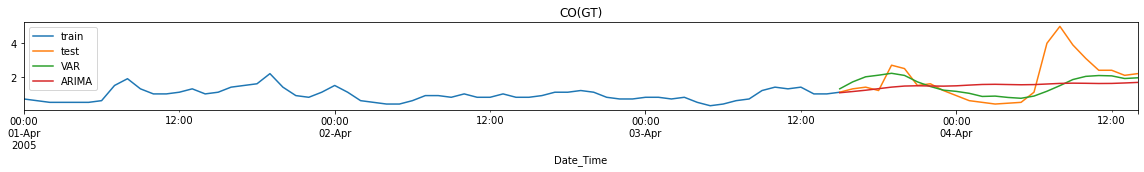

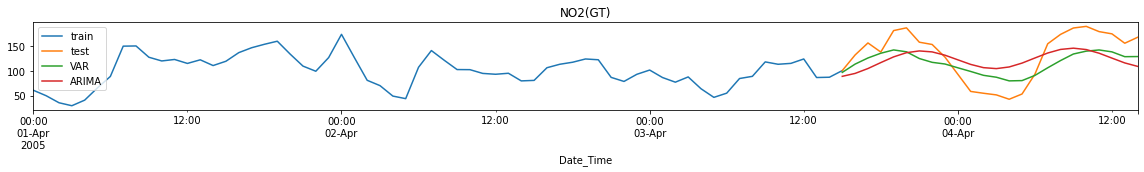

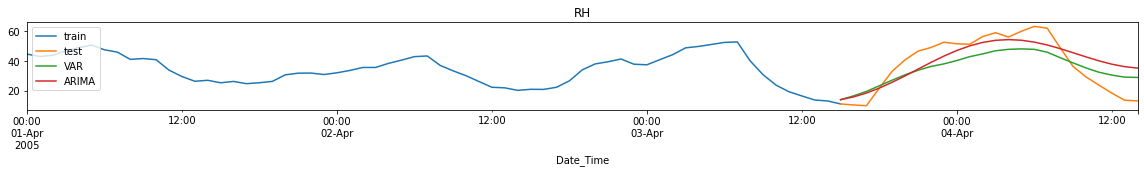

In [24]:
forecasts = pd.concat([forecast_arima, forecast_var], axis=1)
for c in cols:
    fig, ax = utils.plot_forecasts_static(train_df=train_df,
                                          test_df=test_df, 
                                          forecast_df=forecasts, 
                                          column_name=c,
                                          min_train_date='2005-04-01', 
                                          suffix=['-VAR', '-ARIMA'],
                                          title=c)


**Performance Metrics**:

In [25]:
pd.concat([utils.test_performance_metrics(test_df, forecast_var, suffix='-VAR'),
           utils.test_performance_metrics(test_df, forecast_arima, suffix='-ARIMA')], axis=1)

,CO(GT)-VAR,NO2(GT)-VAR,RH-VAR,CO(GT)-ARIMA,NO2(GT)-ARIMA,RH-ARIMA
MAE,0.678041,31.711149,9.932015,0.900467,39.124844,8.927637
MSE,1.197003,1234.428682,116.545989,1.471549,1816.631530,119.039837
MAPE,39.039852,29.188694,35.612265,71.587019,41.149424,38.892921


**Observation/s**:

- MAE: VAR forecasts have lower errors than ARIMA forecasts for CO and NO2 but not in RH.
- MSE: VAR forecasts have lower errors for all variables (CO, NO2 and RH).
- MAPE: VAR forecasts have lower errors for all variables (CO, NO2 and RH). 
- Training time is significantly reduced when using VAR compared to ARIMA (<0.1s run time for VAR while ~20s for ARIMA)

## Structural Analysis

### Impulse Response Function (IRF)

- Coefficients of the VAR models are often difficult to interpret so practitioners often estimate the impulse response function. 
- IRFs trace out the time path of the effects of an exogenous shock to one (or more) of the endogenous variables on some or all of the other variables in a VAR system.
- IRF traces out the response of the dependent variable of the VAR system to shocks (also called innovations or impulses) in the error terms. 

###### IRF in the VAR system for Air Quality 

Let $y_{1,t}$, $y_{2,t}$ and $y_{3,t}$ be the time series corresponding to CO signal, NO2 signal, and RH signal, respectively. Consider the moving average representation of the system shown below:

\begin{equation*}
\begin{bmatrix}
y_{1,t} \\
y_{2,t} \\
y_{3,t}
\end{bmatrix} = 
\begin{bmatrix}
\mu_{1} \\
\mu_{2} \\
\mu_{3}
\end{bmatrix} + 
\sum_{i=0}^\infty
\begin{bmatrix}
\theta_{1,1} & \theta_{1,2} & \theta_{1,3}\\
\theta_{2,1} & \theta_{2,2} & \theta_{2,3}\\
\theta_{3,1} & \theta_{3,2} & \theta_{3,3}\\
\end{bmatrix} 
\begin{bmatrix}
u_{1,t-i} \\
u_{2,t-i} \\
u_{3,t-i}
\end{bmatrix}
\end{equation*}

Suppose $u_1$ in the first equation increases by a value of one standard deviation. 
- This shock will change $y_1$ in the current as well as the future periods.
- This shock will also have an impact on $y_2$ and $y_3$. 

Suppose $u_2$ in the first equation increases by a value of one standard deviation. 
- This shock will change $y_2$ in the current as well as the future periods.
- This shock will also have an impact on $y_1$ and $y_3$. 

Suppose $u_3$ in the first equation increases by a value of one standard deviation. 
- This shock will change $y_3$ in the current as well as the future periods.
- This shock will also have an impact on $y_1$ and $y_2$. 

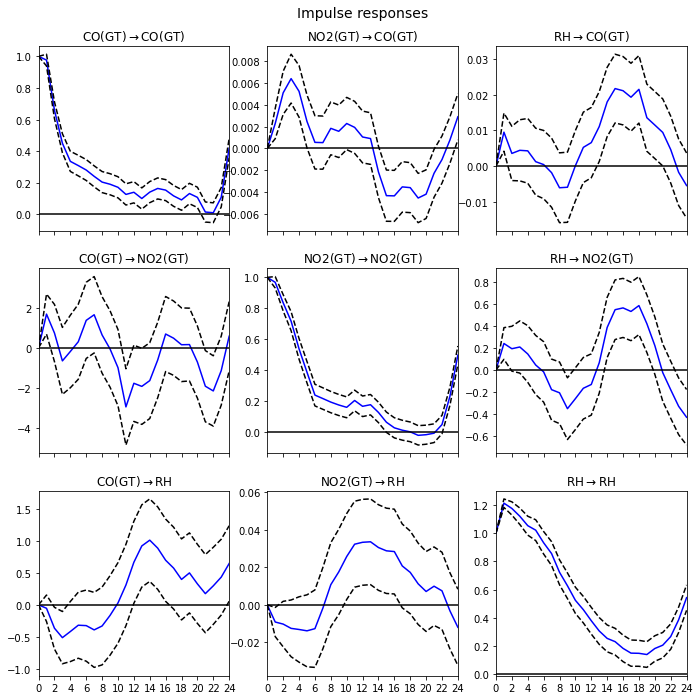

In [26]:
irf = var_model.irf(24)
ax = irf.plot(orth=False)
plt.xlim(0, 24)
plt.xticks(np.arange(0, 25, 2))
plt.show()

**Observation/s:**

Effects of exogenous perturbation/shocks (1SD) of a variable on itself:
- CO $\rightarrow$ CO: A shock in the value of CO has a larger effect CO in the early hours but this decays over time. Interestingly, the effect starts to increase again by the 24th hour. 
- NO2 $\rightarrow$ NO2: A shock in the value of NO2 has a larger effect NO2 in the early hours but this decays over time. The effect increased again after 20 hours. 
- RH $\rightarrow$ RH: A shock in the value of RH has a largest effect in RH after 1 hour and this effect decays over time. The effect increased again after 18 hours. 

Effects of exogenous perturbation/shocks of a variable on another:
- CO $\rightarrow$ NO2: The effect of the shock in the value of CO on NO2 seems to be erratic. We see a strong effect in terms of the magnitude of the IRF but direction shifts between positive to negative over time.  
- CO $\rightarrow$ RH: On the earlier hours, the effect of a shock in CO is negative but becomes positive after 10 hours. In terms of magnitude, there seems to be a delayed stronger effect. 
- NO2 $\rightarrow$ CO: A shock in NO2 only causes a small effect in the values of CO
- NO2 $\rightarrow$ RH: A shock in NO2 only causes a small effect in the values of RH
- RH $\rightarrow$ CO: A shock in RH only causes a small effect in the values of CO
- RH $\rightarrow$ NO2: A shock in RH seems to have an erratic effect on NO2 since the direction shifts positive and negative. However, magnitude-wise, we see that effect of the shock in RH seems to be stronger at later hours. 






### Forecast Error Variance Decomposition (FEVD)
- FEVD indicates the amount of information each variable contributes to the other variables in the autoregression
- While impulse response functions trace the effects of a shock to one endogenous variable on to the other variables in the VAR, variance decomposition separates the variation in an endogenous variable into the component shocks to the VAR.
- It determines how much of the forecast error variance of each of the variables can be explained by exogenous shocks to the other variables.


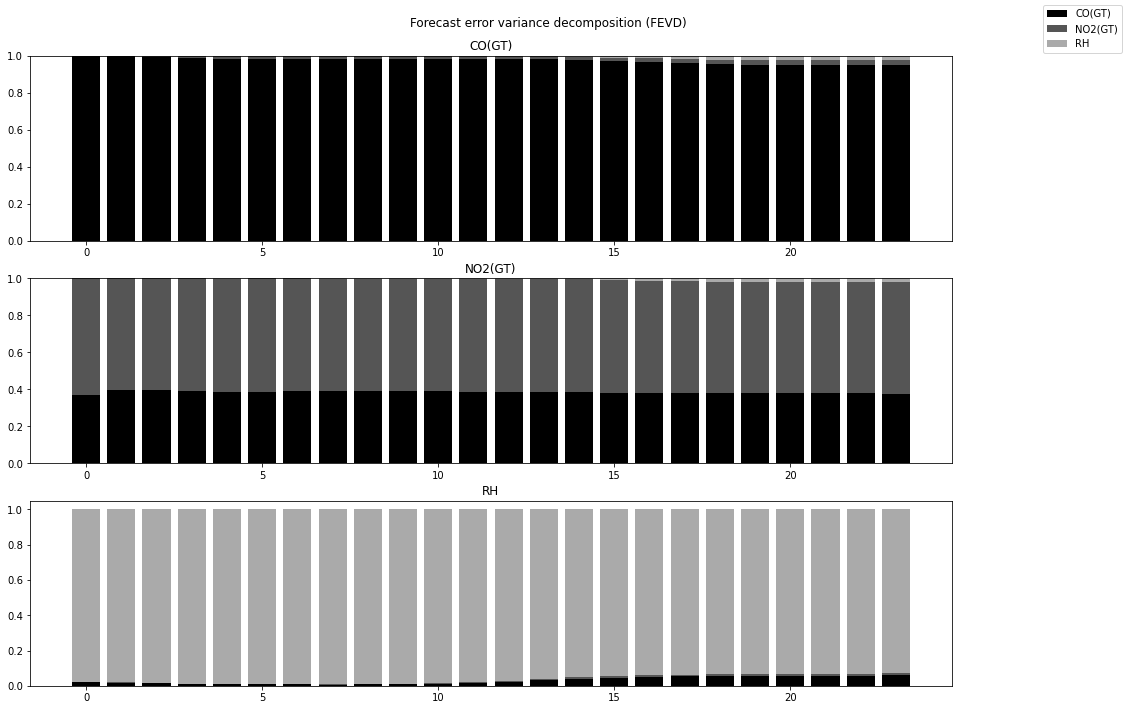

In [27]:
fevd = var_model.fevd(24)
ax = fevd.plot(figsize=(16, 10))
# plt.tight_layout()
plt.show()

**Observation/s:**
* For CO, the variance is mostly explained by exogenous shocks to CO. This decreases over time but only by a small amount. 
* For NO2, the variance is mostly explained by exogenous shocks to NO2 and CO. 
* For RH, the variance is mostly explained by exogenous shocks to RH. Over time, the contribution of the exogenous shocks to CO increases.  

### Forecasting the Jena Weather data

We try to forecast the Jena weather data using the method outlined above. For now, we'll only be using the last 10,000 data points available in the dataset. 

In [28]:
jena_data_sample = jena_data.iloc[-10000:]

In [29]:
%%time
test_stat, p_val = [], []
cv_1pct, cv_5pct, cv_10pct = [], [], []
for c in jena_data_sample.columns: 
    adf_res = adfuller(jena_data_sample[c].dropna())
    test_stat.append(adf_res[0])
    p_val.append(adf_res[1])
    cv_1pct.append(adf_res[4]['1%'])
    cv_5pct.append(adf_res[4]['5%'])
    cv_10pct.append(adf_res[4]['10%'])
adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct}, 
                         index=jena_data_sample.columns).T
adf_res_df.round(4)

CPU times: user 13 s, sys: 2.02 s, total: 15 s
Wall time: 3.9 s


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Test statistic,-2.5615,-5.3932,-4.9907,-3.9679,-9.4216,-5.3657,-3.8384,-9.9704,-3.8128,-3.8148,-3.9943,-8.3022,-7.5758,-8.0519
p-value,0.1012,0.0000,0.0000,0.0016,0.0000,0.0000,0.0025,0.0000,0.0028,0.0028,0.0014,0.0000,0.0000,0.0000
Critical value - 1%,-3.4310,-3.4310,-3.4310,-3.4310,-3.4310,-3.4310,-3.4310,-3.4310,-3.4310,-3.4310,-3.4310,-3.4310,-3.4310,-3.4310
Critical value - 5%,-2.8618,-2.8618,-2.8618,-2.8618,-2.8618,-2.8618,-2.8618,-2.8618,-2.8618,-2.8618,-2.8618,-2.8618,-2.8618,-2.8618
Critical value - 10%,-2.5669,-2.5669,-2.5669,-2.5669,-2.5669,-2.5669,-2.5669,-2.5669,-2.5669,-2.5669,-2.5669,-2.5669,-2.5669,-2.5669


In [30]:
((adf_res_df.loc['Test statistic']< adf_res_df.loc['Critical value - 1%']) & 
(adf_res_df.loc['Test statistic']< adf_res_df.loc['Critical value - 5%']) &
( adf_res_df.loc['Test statistic']< adf_res_df.loc['Critical value - 10%']))

p (mbar)           False
T (degC)            True
Tpot (K)            True
Tdew (degC)         True
rh (%)              True
VPmax (mbar)        True
VPact (mbar)        True
VPdef (mbar)        True
sh (g/kg)           True
H2OC (mmol/mol)     True
rho (g/m**3)        True
wv (m/s)            True
max. wv (m/s)       True
wd (deg)            True
dtype: bool

**Observation/s**: 

From the values above, all the components of the Jena weather data are stationary except for p (mbar), so we'll exclude this in our prediction. 

In [31]:
jena_data_sample = jena_data_sample.drop(['p (mbar)'], axis=1)

In [32]:
%%time
split_index = 144
train_df, test_df = jena_data_sample.iloc[:-split_index], jena_data_sample.iloc[-split_index:]

CPU times: user 3.03 ms, sys: 377 µs, total: 3.41 ms
Wall time: 852 µs


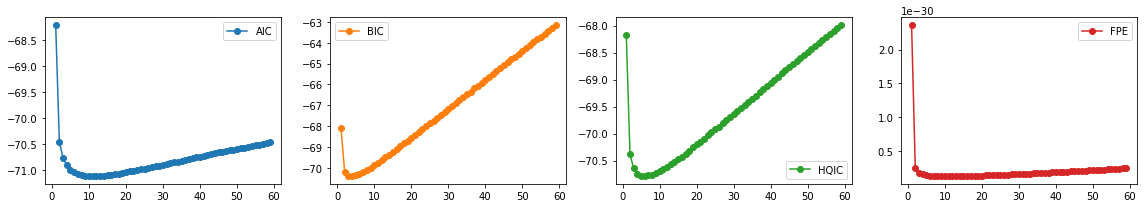

In [33]:
aic, bic, fpe, hqic = [], [], [], []
model = VAR(train_df)
p = np.arange(1,60)
for i in p:
    result = model.fit(i)
    aic.append(result.aic)
    bic.append(result.bic)
    fpe.append(result.fpe)
    hqic.append(result.hqic)
lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                'BIC': bic, 
                                'HQIC': hqic,
                                'FPE': fpe}, 
                               index=p)    
fig, ax = plt.subplots(1, 4, figsize=(16, 3), sharex=True)
lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
plt.tight_layout()

In [34]:
lags_metrics_df.idxmin()

AIC     11
BIC      4
HQIC     6
FPE     11
dtype: int64

We choose $p = 4$. 

In [35]:
%%time
var_model = model.fit(4)

CPU times: user 99.4 ms, sys: 35 ms, total: 134 ms
Wall time: 61.9 ms


In [36]:
forecast_var = pd.DataFrame(var_model.forecast(train_df.values, 
                                              steps=144), 
                           columns=train_df.columns, 
                           index=test_df.index)
forecast_var = forecast_var.rename(columns={c: c+'-VAR' for c in forecast_var.columns})

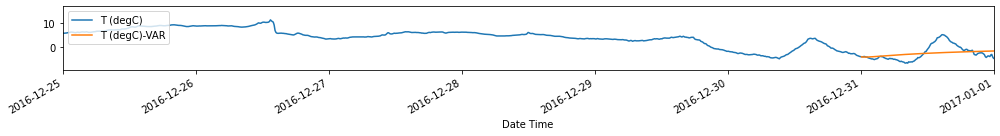

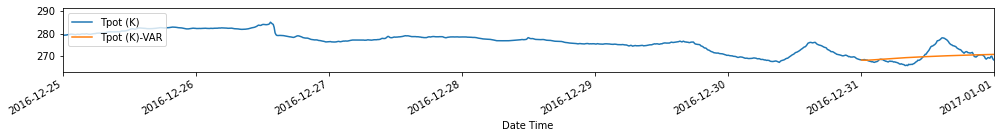

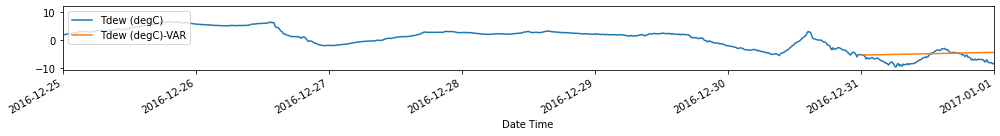

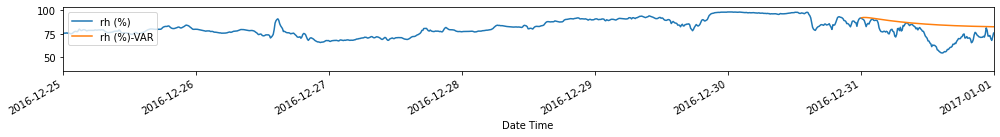

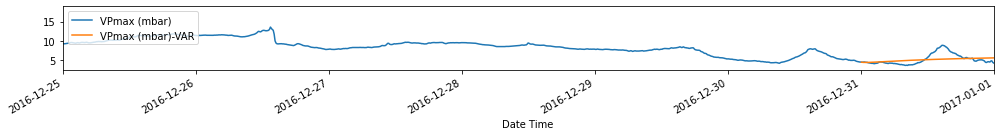

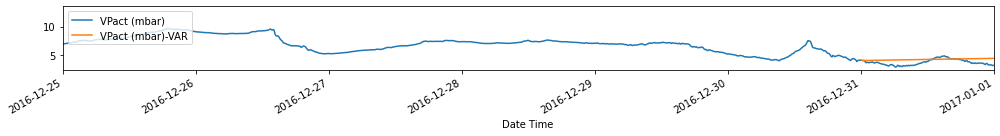

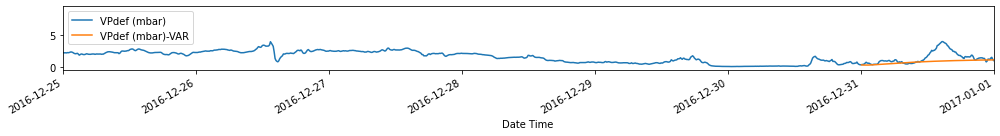

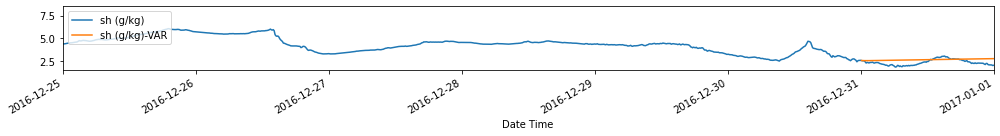

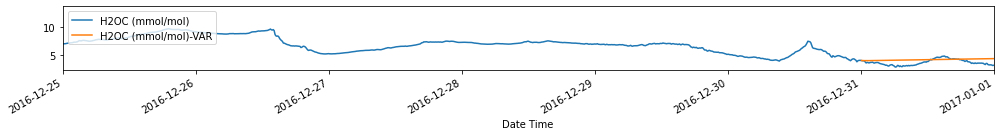

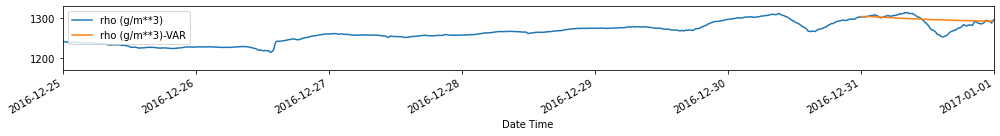

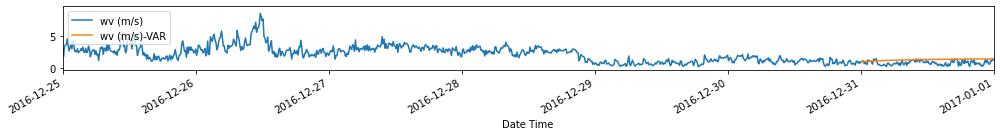

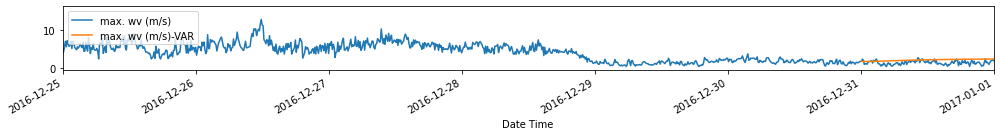

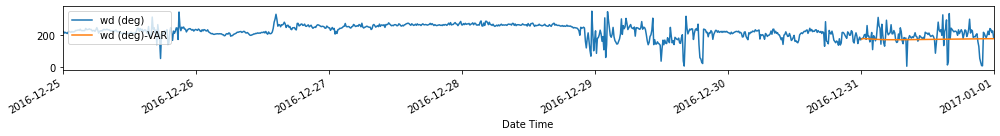

In [37]:
for c in jena_data_sample.columns:
    fig, ax = plt.subplots(figsize=[14, 2])
    jena_data_sample[c].plot(ax=ax)
    forecast_var[[c+'-VAR']].plot(ax=ax)
    plt.xlim(left=pd.to_datetime('2016-12-25'), right=pd.to_datetime('2017-01-01'))
    plt.legend(loc=2)
    plt.tight_layout()
    plt.show()

In [39]:
utils.test_performance_metrics(test_df, forecast_var, suffix='-VAR')

,T (degC)-VAR,Tpot (K)-VAR,Tdew (degC)-VAR,rh (%)-VAR,VPmax (mbar)-VAR,VPact (mbar)-VAR,VPdef (mbar)-VAR,sh (g/kg)-VAR,H2OC (mmol/mol)-VAR,rho (g/m**3)-VAR,wv (m/s)-VAR,max. wv (m/s)-VAR,wd (deg)-VAR
MAE,2.292635,2.291919,1.975916,11.822325,0.925449,0.600680,0.688951,0.366852,0.587636,12.231235,0.510983,0.757384,42.771166
MSE,8.999428,9.690842,5.431729,200.859958,1.620147,0.491925,1.119863,0.182679,0.468760,289.708881,0.361360,0.779419,3357.543785
MAPE,136.294726,0.841055,28.169982,17.646228,16.422789,17.343261,36.754304,17.062372,17.018862,0.957861,102.551197,74.595076,79.960587


## Takeaways
* VAR methods are useful when dealing with multivariate time series, as they allow us to use the relationship between the different variable to forecast. 
* These models allow us to forecast the different variables simultaneously, with the added benefit of easy (only 1 hyperparameter) and fast training. 
* Using the fitted VAR model, we can also explain the relationship between variables, and how the perturbation in one variable affects the others by getting the impulse response functions and the variance decomposition of the forecasts. 
* However, the application of these models is limited due to the stationarity requirement for ALL the variables in the multivariate time series. This method won't work well if there is at least one variable that's non-stationary. When dealing with non-stationary multivariate time series, one can explore the use of vector error correction models (VECM). 
* Another limitation of the VAR method is the assumption that all the variables in the system has the same order $p$. 

In the next chapter, we further extend the use of VAR models to explain the relationships between variables in a multivariate time series using **Granger causality**, which is one of the most common ways to elucidate underlying causal mechanisms in time series data.